In [1]:
# We will need some functionality 
from typing import List 

# and from math related libraries
import qutip as qt

import matplotlib.pyplot as plt

# and from qiskit
from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Operator

import numpy as np
import pylab

from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import I, X, Z

from qiskit.utils.mitigation import CompleteMeasFitter


import os
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
#from qiskit.test.mock import FakeVigo
from qiskit.providers.fake_provider import FakeVigo

from qiskit.circuit import Parameter

In [2]:
def create_zz_hamiltonian(num_qubits: int, connectivity: List[List[int]],
                              h_coeffs: List[float]) -> np.ndarray:
    """Creates a global Hamiltonian consisting of a sum of one (g * Z^i.Z^j) term per device connection.

    Args:
        num_qubits (int): number of qubits of the Hamiltonian
        connectivity (List[List[int]]): connectivity of the device
        h_coeffs (List[float]): list of coefficients of each ZZ term

    Returns:
        np.ndarray: tensored Hamiltonian
    """
    
    dim = 2 ** num_qubits
    num_connections = len(connectivity)
    zz_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)

    # create a matrix that is the sum of ZZ operators on all connected qubits,
    # tensored with the identity
    for c in range(num_connections):
        ops_to_tensor = [qt.identity(2)] * num_qubits
        ops_to_tensor[connectivity[c][0]] = qt.sigmaz()
        ops_to_tensor[connectivity[c][1]] = qt.sigmaz()
        zz_hamiltonian += h_coeffs[c] * np.array(qt.tensor(ops_to_tensor))

    return zz_hamiltonian

In [3]:
#qubits_count = 2
#coeff = 1.
#chain_connections = []
#interaction_strengths = [coeff for i in range(qubits_count)]
#for i in range(qubits_count-1):
#    chain_connections.append([i,i + 1])

#hamiltonian = create_zz_hamiltonian(qubits_count,chain_connections, interaction_strengths) 
#ham_block = HamiltonianGate(data=hamiltonian, time=2) 

In [7]:
#og_op = (-1.052373245772859 * I ^ I) + (0.39793742484318045 * I ^ Z) + (-0.39793742484318045 * Z ^ I) + (-0.01128010425623538 * Z ^ Z) + (0.18093119978423156 * X ^ X)
qubits_count = 2
coeff = 2.
H2_op = coeff * Z
for i in range(qubits_count-1):
    H2_op ^= Z

hamiltonian = H2_op.to_matrix()
ham_block = HamiltonianGate(data=hamiltonian, time=2) 

print(f'Number of qubits: {H2_op.num_qubits}')

Number of qubits: 2


In [8]:

def rotate_circuit(rot_angle,num_qubits,analog_block):
    # First we need to define at least one variational parameter
    #theta = Parameter('a')
    #psi = Parameter('b')
    rot = rot_angle*2

    qr = QuantumRegister(num_qubits)
    ansatz = QuantumCircuit(qr)

    #ansatz.x(0)
    #ansatz.h(1)
    ansatz.r(rot,0.0,0)
    ansatz.unitary(analog_block, [qr[i] for i in range(num_qubits)], label='analog block')
    ansatz.measure_all()


    # Create a quantum circuit that is used for the ansatz
    #ansatz = QuantumCircuit(H2_op.num_qubits)

    # add some single-qubit gates
    #for i in range(no_qubits-1):
    #    if i % 2 == 0:
    #        ansatz.rx(psi, i)

    #ansatz.rz(theta, range(no_qubits))

    # add a chain of CNOTs (multi-qubit gates)
    #for i in range(no_qubits-1):
    #    ansatz.cx(i, i+1)
    #ansatz.cx(no_qubits-1,0)
    #ansatz.barrier()

    return ansatz

VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.96875
VQE on Aer qasm simulator (with noise and measurement error mitigation): -2.00000
VQE on Aer qasm simulator (with noise and measurement error mitigation): -2.00000
VQE on Aer qasm simulator (with noise and measurement error mitigation): -2.00000
VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.98828


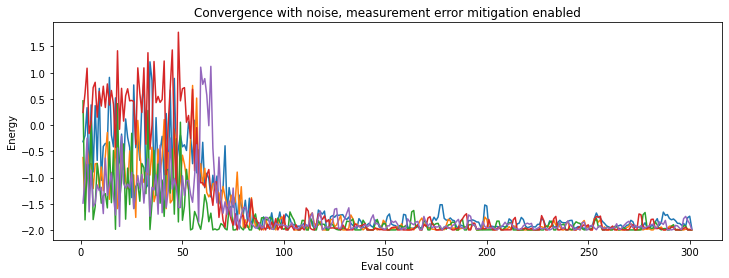

In [9]:

device_backend = FakeVigo()

backend = Aer.get_backend('aer_simulator')
noise_model = None
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

seed = 170
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed) 

algorithm_globals.random_seed = seed
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model, 
                     measurement_error_mitigation_cls=CompleteMeasFitter, 
                     cals_matrix_refresh_period=30)

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

calced_vals = []
points = 5
angles = [i*np.pi/points for i in range(points)]
for i in range(points):
    counts = []
    values = []
    
    angle = angles[i]
    rot_ansatz = rotate_circuit(angle,qubits_count,ham_block)
    rot_ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
    spsa = SPSA(maxiter=iterations)
    vqe = VQE(rot_ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)


    result = vqe.compute_minimum_eigenvalue(operator=H2_op)
    final_eigval = result.eigenvalue.real
    calced_vals.append(final_eigval)
    print(f'VQE on Aer qasm simulator (with noise and measurement error mitigation): {result.eigenvalue.real:.5f}')
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(counts, values)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise, measurement error mitigation enabled');

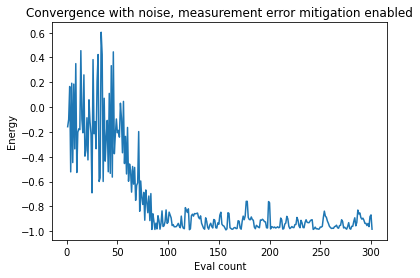

In [7]:
pylab.rcParams['figure.figsize'] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergence with noise, measurement error mitigation enabled');